In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # visualization
import seaborn as sns # visualization
# machine learning
import torch 
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms, datasets, models

import progressbar

In [2]:
# implemented classes
from BasicClassifier import BasicClassifier
from DataAugment import DataAug
from Metrics import Metrics

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [4]:
widgets = [
    ' [', progressbar.Timer(), '] ',
    progressbar.Percentage(), ' ',
    progressbar.Bar(),
    ' (', progressbar.ETA(), ') ',
]

In [5]:
# import mnist dataset
dataset = "MNIST"
BATCH_SIZE = 500
num_classes = 10

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./data',
                               train=False,
                               download=True,
                               transform=torchvision.transforms.ToTensor()),
    batch_size=BATCH_SIZE,shuffle=True)

d:\dmarq\tools\python37\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [6]:
# # import emnist dataset
# dataset = "EMNIST"
# BATCH_SIZE = 500
# num_classes = 47

# test_loader = torch.utils.data.DataLoader(
#     torchvision.datasets.EMNIST('./data',
#                                 split="balanced",
#                                train=False,
#                                download=True,
#                                transform=torchvision.transforms.ToTensor()),
#     batch_size=BATCH_SIZE,shuffle=True)

In [7]:
daug = DataAug()
metric = Metrics()

In [8]:
def display_testing_metrics(name,epoch_metrics):
    sns.lineplot(x=list(epoch_metrics.keys()),y=np.array(list(epoch_metrics.values()),dtype=float)[:,1]) # precision
    sns.lineplot(x=list(epoch_metrics.keys()),y=np.array(list(epoch_metrics.values()),dtype=float)[:,2]) # recall
    sns.lineplot(x=list(epoch_metrics.keys()),y=np.array(list(epoch_metrics.values()),dtype=float)[:,0],) # accuracy
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.xlabel('% loss')
    plt.title(name)
    
def display_testing_metrics_hist(name,metrics):
    sns.barplot(x=['accuracy','precision','recall'],y=metrics[0:3])
    plt.ylim([0, 1])
    plt.title(name)

In [9]:
func_dict = {'rand_pixel':getattr(daug, 'rand_pixel'),
             'rand_row':getattr(daug, 'rand_row'),
             'rand_column':getattr(daug, 'rand_column'),
             'rand_rowcol':getattr(daug, 'rand_rowcol'),
             'rand_block':getattr(daug, 'rand_rowcol'),
             #'pattern_checkerboard':getattr(daug,'pattern_checkerboard'),
             #'pattern_column':getattr(daug,'pattern_column'),
             #'pattern_row':getattr(daug,'pattern_row')
            }

model_dict = {'unaltered':None,
              'rand_pixel':None,
              'rand_row':None,
              'rand_column':None,
              'rand_rowcol':None,
              #'rand_block':None,
              #'pattern_checkerboard':None,
              #'pattern_column':None,
              #'pattern_row':None,
              'rand_row & rand_column':None}
# import models
proportion = 0.5
for name in model_dict:
    model_dict[name] = BasicClassifier(num_classes)
    if name[0] == 'r':
        model_dict[name].load_state_dict(torch.load('./models/{}/train({})/{}.h5'.format(dataset,proportion,name),map_location=device))
    else:
        model_dict[name].load_state_dict(torch.load('./models/{}/train({})/{}.h5'.format(dataset,"definite",name),map_location=device))

In [10]:
crosstab_hist = {mname:{fname:{} for fname in func_dict} for mname in model_dict}
rel_frequency_hist = {fname:[] for fname in func_dict}
test_proportion = 0.7
rel_pixel_threshold = 0.0

bar = progressbar.ProgressBar(len(func_dict),widgets=widgets).start()
# for cc, model_name in enumerate(model_dict):
for dd, func_name in enumerate(func_dict):
    rel_freq = []
    for name in model_dict:
        model_dict[name].metric.reset_confusion_matrix(num_classes)

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_loader):
            lossyinputs = func_dict[func_name](inputs=inputs,proportion=test_proportion) # by default same as training
            for model_name in model_dict:
                outputs = model_dict[model_name](lossyinputs.to(device))
                # statistics
                model_dict[model_name].metric.update_confusion_matrix(outputs.to('cpu'),labels)
                # statistics on frequency of lost relevant pixels
                rel_freq = np.concatenate((rel_freq,(((inputs > rel_pixel_threshold).sum(2).sum(2) - (lossyinputs > rel_pixel_threshold).sum(2).sum(2))/(inputs > rel_pixel_threshold).sum(2).sum(2)).reshape(-1).to('cpu').numpy()))
        # progressbar
        bar.update(dd)
        for model_name in model_dict:
            crosstab_hist[model_name][func_name] = model_dict[model_name].metric.classification_metrics() # we just want the metrics for a single proportion
        rel_frequency_hist[func_name] = rel_freq

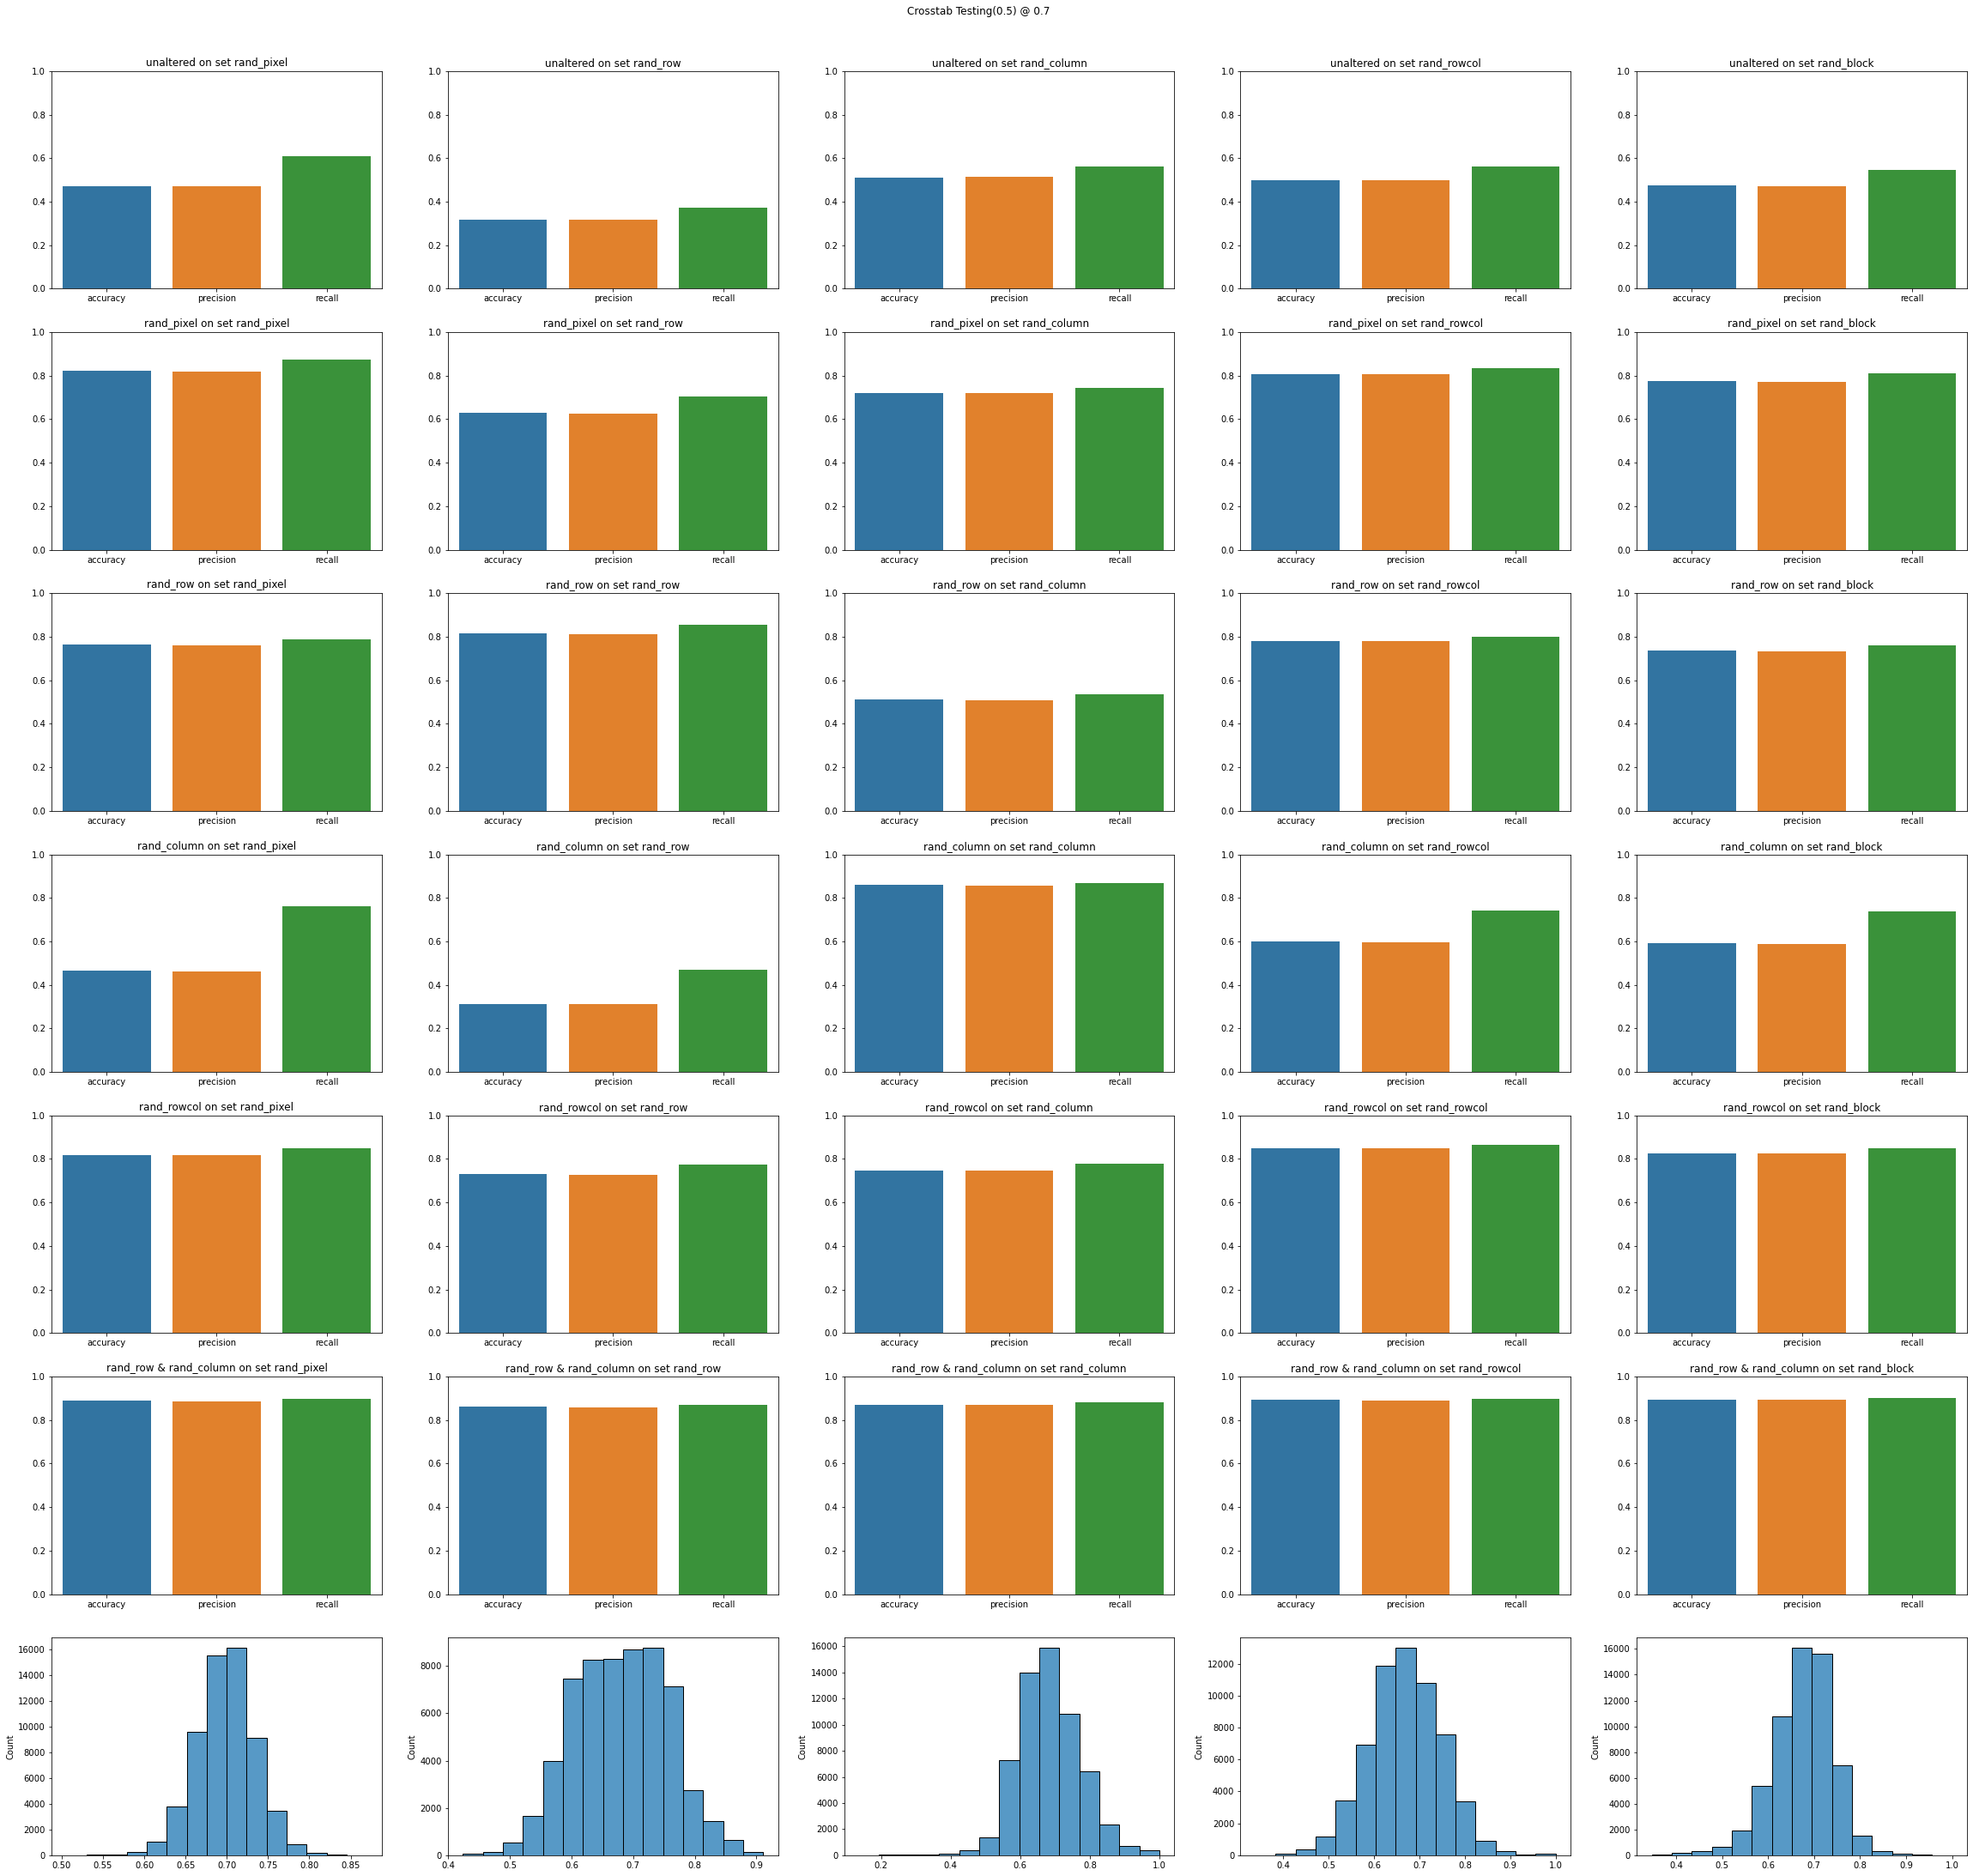

In [11]:
fig, axarr = plt.subplots(len(crosstab_hist.keys())+1, len(crosstab_hist[list(crosstab_hist.keys())[0]].keys()),figsize=(40,35))
for i, model in enumerate(crosstab_hist.keys()):
    for j, func in enumerate(crosstab_hist[model].keys()):
        plt.sca(axarr[i, j]) 
        display_testing_metrics_hist("{} on set {}".format(model,func),crosstab_hist[model][func])
for j, func_name in enumerate(rel_frequency_hist):
    plt.sca(axarr[len(crosstab_hist.keys()), j]) 
    sns.histplot(rel_frequency_hist[func_name],bins=15)
plt.suptitle('Crosstab Testing({}) @ {}'.format(proportion,test_proportion))
fig.subplots_adjust(top=0.95)
plt.show()